<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA-25/blob/main/lesson_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---

# Занятие №11
# Задача регрессии, на примере определения расхода потребляемого топлива на ТЭЦ
# PyTorch Lightning
**23 апреля 2025г.**

Задача **регрессии** — это тип задачи машинного обучения, в которой модель предсказывает **непрерывное числовое значение** на основе входных данных.

Примеры задач регрессии:
- Предсказание температуры воздуха по времени суток, влажности и скорости ветра.
- Оценка стоимости недвижимости по характеристикам (площадь, этаж, район и т.п.).
- Прогнозирование выработки электроэнергии турбиной по текущим параметрам работы.
- Прогнозирование вещественного числа на основании предыдущих значений (прогноз потребления электроэнергии)

**Формально:**  
Если входные данные обозначить как $ X $, а целевое значение как $ y $, то задача регрессии — найти функцию $ f $, такую что:
$$ y = f(X) + \varepsilon, $$
где $ \varepsilon $ — шум (ошибка), а $ y $ — непрерывная величина (например, вещественное число).

**В отличие от классификации**, где ответ — это метка (например, "да"/"нет", "норма"/"авария"), в регрессии результат — число, которое может принимать бесконечное множество значений.

Если модель предсказывает вектор непрерывных чисел, это всё ещё задача регрессии, просто в многомерной форме. Это называется **Многомерная регрессия (Multivariate Regression)** или **Мультиаутпут регрессия (Multi-output Regression)**.

In [ ]:
!pip install pytorch-lightning

import pandas as pd
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import callbacks, cli_lightning_logo, LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers.mlflow import MLFlowLogger

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

torch.manual_seed(42);

## Загрузка данных

In [ ]:
import gdown
import warnings
warnings.filterwarnings('ignore')
gdown.download('https://drive.google.com/uc?id=17YX6P0YMTx12oNVPcuwGAQgKLOkA5Efy', verify=False)
gdown.download('https://drive.google.com/uc?id=17_utMiYF01v1eDJeqkua8JNDzlQ6_pBe', verify=False)

Downloading...
From: https://drive.google.com/uc?id=17YX6P0YMTx12oNVPcuwGAQgKLOkA5Efy
To: /content/turbohackathon_task2_df2.csv
100%|██████████| 64.7k/64.7k [00:00<00:00, 36.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=17_utMiYF01v1eDJeqkua8JNDzlQ6_pBe
To: /content/turbohackathon_task2_df1.csv
100%|██████████| 555k/555k [00:00<00:00, 87.6MB/s]


'turbohackathon_task2_df1.csv'

In [ ]:
df1 = pd.read_csv("turbohackathon_task2_df1.csv", parse_dates=["data"], index_col="data")
df2 = pd.read_csv("turbohackathon_task2_df2.csv", parse_dates=["date"], index_col="date")

In [ ]:
df1.head()

,TG4_kWhr,TG5_kWhr,TG6_kWhr,TG9_kWhr,TG10_kWhr,sum_kWhr,B_1e3m3,Q_gcalhr
data,,,,,,,,
2023-01-01 00:00:00.000,0.0,53088.0,47988.0,98208.0,0.0,199284.0,93.67,169
2023-01-01 01:00:00.000,0.0,53088.0,48012.0,98192.0,0.0,199292.0,93.72,167
2023-01-01 01:59:59.990,0.0,53097.6,48024.0,98176.0,0.0,199297.6,93.79,165
2023-01-01 02:59:59.985,0.0,53068.8,47832.0,96992.0,0.0,197892.8,92.62,156
2023-01-01 03:59:59.980,0.0,53088.0,47772.0,96320.0,0.0,197180.0,92.23,151


In [ ]:
df1.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7344 entries, 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TG4_kWhr   7344 non-null   float64
 1   TG5_kWhr   7344 non-null   float64
 2   TG6_kWhr   7344 non-null   float64
 3   TG9_kWhr   7344 non-null   float64
 4   TG10_kWhr  7344 non-null   float64
 5   sum_kWhr   7344 non-null   float64
 6   B_1e3m3    7344 non-null   float64
 7   Q_gcalhr   7344 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 516.4 KB


In [ ]:
df2.head()

,TG4,TG5,TG6,TG9,TG10,SB4,SB5,SB6,SB8,SB9,...,tower_5a,tower_5b,tower_6a,tower_6b,tower_7a,tower_7b,Ifwp_kWhrton,tamb,WB,Gfw
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,0,1,1,1,0,0,0,1,1,1,...,1,1,1,1,0,0,7.35,-6.4,0,1124.625000
2023-01-02,0,1,1,1,0,0,0,1,1,1,...,1,1,1,1,0,0,7.38,-2.6,0,1112.958333
2023-01-03,0,1,1,1,0,0,2,2,1,1,...,1,1,1,1,0,0,7.63,-1.7,0,1101.333333
2023-01-04,0,1,1,1,0,0,1,0,1,1,...,1,1,1,1,0,0,7.34,-3.5,0,1109.875000
2023-01-05,0,1,1,1,0,0,1,0,1,1,...,1,1,1,1,0,0,7.24,-11.9,0,1154.833333


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 2023-01-01 to 2023-12-31
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TG4            276 non-null    int64  
 1   TG5            276 non-null    int64  
 2   TG6            276 non-null    int64  
 3   TG9            276 non-null    int64  
 4   TG10           276 non-null    int64  
 5   SB4            276 non-null    int64  
 6   SB5            276 non-null    int64  
 7   SB6            276 non-null    int64  
 8   SB8            276 non-null    int64  
 9   SB9            276 non-null    int64  
 10  SB10           276 non-null    int64  
 11  OB1A           276 non-null    int64  
 12  OB1B           276 non-null    int64  
 13  OB2A           276 non-null    int64  
 14  OB2B           276 non-null    int64  
 15  OB3A           276 non-null    int64  
 16  OB3B           276 non-null    int64  
 17  SPG1           276 non-null    int6

## Постановка задачи

По заданному составу основного оборудования (турбогенераторы, паровые и водогрейные котлы) и значениям суммарной электрической и тепловой нагрузок ТЭЦ определить расход потребляемого топлива и распределение электрической нагрузки по агрегатам.

In [ ]:
# Удалим данные когда оборудование работало не полные сутки,
# чтобы исключить пусковые потери

df2 = df2[df2['TG9'] != 2]
df2 = df2[df2['TG5'] != 2]
df2 = df2[df2['TG4'] != 2]
df2 = df2[df2['TG6'] != 2]
df2 = df2[df2['TG10'] != 2]
df2 = df2[df2['WB'] != 2]

df2 = df2[df2['SB4'] != 2]
df2 = df2[df2['SB5'] != 2]
df2 = df2[df2['SB6'] != 2]
df2 = df2[df2['SB8'] != 2]
df2 = df2[df2['SB9'] != 2]
df2 = df2[df2['SB10'] != 2]

In [ ]:
# Приведем датафреймы к одно дискретизации и объединим их

df = pd.concat([df2, df1.resample('1d').mean().loc[df2.index,:]], axis=1)

In [ ]:
df.head()

,TG4,TG5,TG6,TG9,TG10,SB4,SB5,SB6,SB8,SB9,...,WB,Gfw,TG4_kWhr,TG5_kWhr,TG6_kWhr,TG9_kWhr,TG10_kWhr,sum_kWhr,B_1e3m3,Q_gcalhr
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,0,1,1,1,0,0,0,1,1,1,...,0,1124.625000,0.0,53908.608,47466.240000,92968.960000,0.0,194343.808000,91.328000,145.880000
2023-01-02,0,1,1,1,0,0,0,1,1,1,...,0,1112.958333,0.0,58861.200,44393.000000,93388.666667,0.0,196642.866667,90.728333,139.208333
2023-01-04,0,1,1,1,0,0,1,0,1,1,...,0,1109.875000,0.0,56400.800,44633.000000,96481.333333,0.0,197515.133333,90.346250,143.958333
2023-01-05,0,1,1,1,0,0,1,0,1,1,...,0,1154.833333,0.0,57206.400,45658.956522,100843.130435,0.0,203708.486957,93.922609,170.434783
2023-01-06,0,1,1,1,0,0,1,0,1,1,...,0,1170.333333,0.0,56236.800,46083.500000,102098.000000,0.0,204418.300000,95.338333,171.625000


## Анализ

Проверим баланс электроэнергии

In [ ]:
(df['TG4_kWhr'] + df['TG5_kWhr'] + df['TG6_kWhr'] + df['TG9_kWhr'] + df['TG10_kWhr'] - df['sum_kWhr']).max()

2.9103830456733704e-11

Определим все комбинации ТГ

In [ ]:
tg_columns = ["TG4", "TG5", "TG6", "TG9", "TG10"]

tg_combinations = df[tg_columns].apply(
    lambda row: ''.join([col for col in tg_columns if row[col]]),
    axis=1
)

In [ ]:
# tg_combinations.head()

Дополним комбинации ТГ водогрейным котлов

In [ ]:
tg_wb_columns = tg_columns + ["WB"]

tg_wb_combinations = df[tg_wb_columns].apply(
    lambda row: ''.join([col for col in tg_wb_columns if row[col]]),
    axis=1
)

Комбинации всего основного оборудования

In [ ]:
tg_wb_sb_columns = tg_wb_columns + ["SB4", "SB5", "SB6", "SB8", "SB9", "SB10"]

tg_wb_sb_combinations = df[tg_wb_sb_columns].apply(
    lambda row: ''.join([col for col in tg_wb_sb_columns if row[col]]),
    axis=1
)

In [ ]:
df['tg_combinations'] = tg_combinations
df['tg_wb_combinations'] = tg_wb_combinations
df['tg_wb_sb_combinations'] = tg_wb_sb_combinations

In [ ]:
print(df["tg_combinations"].unique().shape[0])
print(df["tg_combinations"].unique())

8
['TG5TG6TG9' 'TG4TG5TG6TG9' 'TG4TG5TG9' 'TG4TG6TG9' 'TG6TG9' 'TG4TG9TG10'
 'TG5TG9TG10' 'TG4TG5TG10']


In [ ]:
print(df["tg_wb_combinations"].unique().shape[0])
print(df["tg_wb_combinations"].unique())

11
['TG5TG6TG9' 'TG4TG5TG6TG9WB' 'TG5TG6TG9WB' 'TG4TG5TG9' 'TG4TG6TG9'
 'TG6TG9' 'TG4TG9TG10' 'TG4TG5TG6TG9' 'TG5TG9TG10' 'TG4TG5TG10'
 'TG4TG6TG9WB']


In [ ]:
print(df["tg_wb_sb_combinations"].unique().shape[0])
print(df["tg_wb_sb_combinations"].unique())

33
['TG5TG6TG9SB6SB8SB9SB10' 'TG5TG6TG9SB5SB8SB9SB10'
 'TG4TG5TG6TG9WBSB4SB6SB8SB9SB10' 'TG5TG6TG9WBSB5SB6SB8SB9'
 'TG5TG6TG9SB5SB6SB8SB9' 'TG5TG6TG9SB5SB6SB8SB10' 'TG4TG5TG9SB5SB6SB8SB10'
 'TG5TG6TG9SB5SB6SB9SB10' 'TG5TG6TG9SB4SB5SB6SB8' 'TG5TG6TG9SB4SB6SB8SB9'
 'TG4TG6TG9SB4SB6SB8SB9' 'TG6TG9SB4SB6SB8SB9' 'TG4TG9TG10SB4SB6SB8SB9'
 'TG4TG6TG9SB4SB8SB9SB10' 'TG5TG6TG9SB4SB6SB9SB10'
 'TG4TG5TG6TG9SB4SB5SB9SB10' 'TG5TG6TG9SB4SB5SB9SB10'
 'TG4TG5TG6TG9SB5SB6SB9SB10' 'TG4TG5TG6TG9SB4SB5SB6SB10'
 'TG5TG6TG9SB4SB5SB6SB10' 'TG5TG9TG10SB4SB5SB6SB10'
 'TG5TG9TG10SB4SB5SB9SB10' 'TG4TG5TG10SB4SB5SB9SB10'
 'TG4TG5TG10SB4SB5SB10' 'TG4TG5TG10SB4SB5SB6SB10' 'TG4TG5TG10SB4SB6SB10'
 'TG4TG5TG10SB4SB5SB6SB8' 'TG4TG5TG6TG9SB4SB5SB6SB8SB10'
 'TG4TG6TG9SB4SB5SB6SB8SB10' 'TG4TG6TG9WBSB4SB5SB6SB8SB10'
 'TG4TG5TG6TG9WBSB4SB5SB6SB8SB10' 'TG4TG6TG9SB4SB5SB6SB8'
 'TG4TG9TG10SB4SB6SB8SB10']


## Выделение признаков и целевых значений

Вспомогательная функция для масштабирования данных

In [ ]:
from typing import Tuple
def trnsfrm(x, scale: bool, norm: bool) -> Tuple[np.ndarray, dict]:
    """
    Transforms the input data using either StandardScaler or MinMaxScaler based on user input.

    Args:
        x (np.ndarray): Input data as a numpy array.
        scale (bool): Flag to apply StandardScaler.
        norm (bool): Flag to apply MinMaxScaler.

    Returns:
        Tuple[np.ndarray, Dict]: Tuple containing the transformed data as a numpy array and a dictionary with information on the applied scaler (mean and standard deviation for StandardScaler, and minimum and maximum values for MinMaxScaler).

    """


    xx = x.copy()
    s = StandardScaler()
    n = MinMaxScaler()
    info = {}
    if scale:
        xx = s.fit_transform(xx)
        info['scale'] = {"mean": s.mean_.tolist(),
                         "std": s.scale_.tolist()}
    elif norm:
        xx = n.fit_transform(xx)
        info['norm'] = {"min_": n.data_min_.tolist(),
                        "max_": n.data_max_.tolist()}
    return s, n, xx, info

In [ ]:
x_labels = ['sum_kWhr', 'Q_gcalhr', 'tamb',
            's10ata_tonhr', 's16ata_tonhr', 's30ata_tonhr',
            'TG4', 'TG5', 'TG6', 'TG9', 'TG10',
            'SB4', 'SB5', 'SB6', 'SB8', 'SB9', 'SB10',
            'WB',]
y_labels = ['TG4_kWhr', 'TG5_kWhr', 'TG6_kWhr',
            'TG9_kWhr', 'TG10_kWhr', 'B_1e3m3']

X = df.loc[:, x_labels]
y = df.loc[:, y_labels]

X = X.values.astype("float32")
y = y.values.astype("float32")

Масштабирование

In [ ]:
s_X, n_X, X, prep_x_info = trnsfrm(X,
            scale=False,
            norm=True)
# prep_x_info['scale_x'] = prep_x_info.pop('scale')


s_y, n_y, y, prep_y_info = trnsfrm(y,
            scale=False,
            norm=True)
# prep_y_info['scale_y'] = prep_y_info.pop('scale')

## Dataset

In [ ]:
class PPDataset(Dataset):
  def __init__(self):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

Разделение на обучающую и тестовую части

In [ ]:
dataset = PPDataset()

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size])

## PyTorch Lightning
**PyTorch Lightning** — это **высокоуровневая обёртка над PyTorch**, которая помогает писать чище и структурированнее код для обучения нейросетей, не теряя гибкости самого PyTorch.

Зачем нужен PyTorch Lightning?
При использовании "чистого" PyTorch, часто получается куча повторяющегося кода:
- обучение (`train`),
- валидация,
- переключение между режимами `.train()` и `.eval()` и т.д.

**Lightning берёт это на себя**, позволяя сосредоточиться только на логике модели.

---

**Основные плюсы:**

**Чистый и модульный код**  
   Всё разбито на понятные методы: `forward()`, `training_step()`, `configure_optimizers()`, и т.д.

### Полносвязная нейронная сеть


### `class FCNN(LightningModule)`
Это реализация **полносвязной нейронной сети (Fully Connected Neural Network, FCNN)** для задачи регрессии или прогнозирования с использованием **PyTorch Lightning**.

---

### `__init__`
**Аргументы конструктора:**
- `input_features` — количество входных признаков.
- `output_features` — размер выходного вектора.
- `hidden_dim` — размер скрытых слоёв (по умолчанию 32).
- `hidden_num` — количество скрытых слоёв (по умолчанию 3).
- `lr` — скорость обучения (learning rate).

**Что делает:**
- Сохраняет параметры.
- Создаёт список скрытых линейных слоёв (`nn.Linear`) в `nn.ModuleList`.
  - Первый слой соединяет вход с первым скрытым слоем.
  - Остальные соединяют скрытые слои между собой.
- Создаёт выходной слой (`self.out`) — последний линейный слой, выдающий предсказание.
- `example_input_array` нужен для экспорта модели и визуализации.

---

### `forward(self, x)`
**Что делает:**
- Последовательно применяет к входу `x` скрытые слои с активацией ReLU.
- Затем применяет выходной линейный слой.
- Возвращает результат (`y_hat`).

---

### `training_step(self, batch, batch_idx)`
- Обрабатывает один батч на тренировке.
- Вызывает `_common_step`, где рассчитывается MSE loss.
- Логирует значение ошибки (`train_loss`).

---

### `validation_step(self, batch, batch_idx)`
- То же, что `training_step`, но на валидации.
- Логирует `val_loss`.

---

### `configure_optimizers(self)`
- Возвращает оптимизатор Adam с заданной скоростью обучения.

---

### `_common_step(self, batch, batch_idx, stage: str)`
- Унифицированная функция для `training_step` и `validation_step`.
- Выполняет forward-pass, считает среднеквадратичную ошибку (`F.mse_loss`), логирует loss.

In [ ]:
class FCNN(LightningModule):
    """
    """

    def __init__(self,
                 input_features: int,
                 output_features: int,
                 hidden_dim = 32,
                 hidden_num=3,
                 lr: float = 1e-3):

        super().__init__()
        self.save_hyperparameters()

        self.layers_size = {'input_features': input_features,
                            'output_features': output_features,
                            'hidden_dim': hidden_dim,
                            'hidden_num': hidden_num}

        self.lr = lr

        self.linear = nn.ModuleList()
        self.hidden_num = hidden_num

        for i in range(hidden_num):
          if i == 0:
            self.linear.append(nn.Linear(input_features, hidden_dim))
          else:
            self.linear.append(nn.Linear(hidden_dim, hidden_dim))
        self.out = nn.Linear(hidden_dim, output_features)

        self.example_input_array = torch.randn(1, input_features)

    def forward(self, x):
      for i in range(self.hidden_num):
        x = F.relu(self.linear[i](x))

      y_hat = self.out(x)
      return y_hat

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def _common_step(self, batch, batch_idx, stage: str):
        x, y = batch
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)

        if stage == "train":
          self.log(f"{stage}_loss", loss, on_step=True, on_epoch=True)
        else:  # val
          self.log(f"{stage}_loss", loss, on_step=False, on_epoch=True)

        return loss

### EarlyStopping (ранняя остановка)
Используется для предотвращения переобучения — остановка обучения, когда модель перестаёт улучшаться.

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

e_stop = EarlyStopping(
    monitor="val_loss",      # Следим за значением val_loss
    min_delta=0.001,         # Минимальное улучшение, чтобы считать его значимым
    patience=3,              # Остановится, если 3 эпохи подряд нет улучшения
    verbose=False,           # Не печатает логи в консоль (можно включить True)
    mode="min"               # Чем меньше val_loss — тем лучше
)

### ModelCheckpoint

Сохраняет чекпоинты по ходу обучения, чтобы потом можно было:
- восстановить лучшую модель;
- продолжить обучение;
- делать инференс.

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoints_dir = './runs'
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoints_dir,                      # Папка, куда сохраняются модели
    monitor='train_loss',                         # Метрика, по которой выбираются лучшие модели
    filename="sample-{epoch:02d}-{train_loss:.2f}-{val_loss:.2f}",  # Имя файла с шаблоном
    save_top_k=5,                                 # Хранить только 5 лучших моделей
    save_weights_only=False                       # Сохранять всю модель, не только веса
)


### Trainer
Trainer — основной объект, который управляет всем процессом обучения: эпохи, батчи, GPU, логирование, чекпоинты, callbacks и т.д.

In [ ]:
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger("logs", name="my_model")

trainer = Trainer(
    logger=logger,
    devices="auto",                      # Автоматически выбрать устройство (GPU/CPU)
    accelerator="auto",                  # Автоматически определить тип ускорителя (cuda, mps, tpu и т.д.)
    log_every_n_steps=2,                 # Частота логирования
    max_epochs=100,                      # Максимум 100 эпох
    enable_checkpointing=True,          # Включить сохранение моделей
    default_root_dir=checkpoints_dir,   # Корень для логов и чекпоинтов
    callbacks=[e_stop, checkpoint_callback]  # Список callback-ов
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Инициализация и обучение модели

In [ ]:
params_info = {'input': x_labels,
               'output': y_labels}

input_features = X.shape[-1]
output_features = y.shape[-1]
hidden_dim = 32
hidden_num = 3
learning_rate = 1e-3

batch_size = 128

In [ ]:
model = FCNN(
    input_features=input_features,
    output_features=output_features,
    hidden_dim=hidden_dim,
    hidden_num=hidden_num,
    lr=learning_rate)
model_layers = {'layers': model.layers_size}

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | linear | ModuleList | 2.7 K  | train | ?        | ?        
1 | out    | Linear     | 198    | train | [1, 32]  | [1, 6]   
---------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Анализ обучения модели

In [ ]:
import pandas as pd
log_df = pd.read_csv("logs/my_model/version_0/metrics.csv")

In [ ]:
log_df.head()

,epoch,step,train_loss_epoch,train_loss_step,val_loss
0,0,1,NaN,0.369612,NaN
1,0,3,NaN,0.382448,NaN
2,0,5,NaN,0.387213,NaN
3,0,5,NaN,NaN,0.349928
4,0,5,0.371458,NaN,NaN


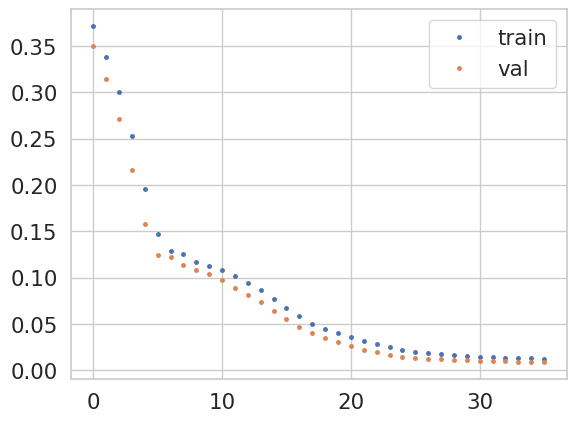

In [ ]:
plt.plot(
    log_df['epoch'], log_df['train_loss_epoch'],
    linestyle='none', marker='.', markersize=5,
    label='train')

plt.plot(
    log_df['epoch'], log_df['val_loss'],
    linestyle='none', marker='.', markersize=5,
    label='val');

plt.legend();

In [ ]:
trainer.logged_metrics

{'train_loss_step': tensor(0.0173),
 'val_loss': tensor(0.0127),
 'train_loss_epoch': tensor(0.0177)}

## Загрузка модели из чекпоинта

In [ ]:
checkpoint_path = 'runs/sample-epoch=63-train_loss=0.02-val_loss=0.01.ckpt'
model_ckpt = FCNN.load_from_checkpoint(checkpoint_path)
model_ckpt.eval()

FCNN(
  (linear): ModuleList(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1-2): 2 x Linear(in_features=32, out_features=32, bias=True)
  )
  (out): Linear(in_features=32, out_features=6, bias=True)
)

## Определим границы каждого возможного состава оборудования

In [ ]:
x_ex = df.sample()[x_labels]
x_ex

,sum_kWhr,Q_gcalhr,tamb,s10ata_tonhr,s16ata_tonhr,s30ata_tonhr,TG4,TG5,TG6,TG9,TG10,SB4,SB5,SB6,SB8,SB9,SB10,WB
date,,,,,,,,,,,,,,,,,,
2023-10-02,137720.8,22.375,13.7,161.5129,23.54167,0.0,1,1,0,0,1,1,1,0,0,0,1,0


In [ ]:
pd.DataFrame(
    n_y.inverse_transform(model_ckpt(torch.tensor(n_X.transform(x_ex.values), dtype=torch.float32)).detach().numpy()),
    columns=y_labels)

,TG4_kWhr,TG5_kWhr,TG6_kWhr,TG9_kWhr,TG10_kWhr,B_1e3m3
0,42700.710938,53678.285156,-6628.354004,12520.900391,44021.746094,76.274551


In [ ]:
x_ex = np.array([[1.904085e+05, 8.937500e+01, 1.070000e+01, 2.650000e+02,
                  1.020000e+02, 4.600000e+01, 0.000000e+00, 1.000000e+00,
                  1.000000e+00, 1.000000e+00, 0.000000e+00,
                  0, 0, 0, 0, 0, 0, 0]])

In [ ]:
pd.DataFrame(x_ex, columns=x_labels)

,sum_kWhr,Q_gcalhr,tamb,s10ata_tonhr,s16ata_tonhr,s30ata_tonhr,TG4,TG5,TG6,TG9,TG10,SB4,SB5,SB6,SB8,SB9,SB10,WB
0,190408.5,89.375,10.7,265.0,102.0,46.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pd.DataFrame(
    n_y.inverse_transform(model_ckpt(torch.tensor(n_X.transform(x_ex), dtype=torch.float32)).detach().numpy()),
    columns=y_labels)

,TG4_kWhr,TG5_kWhr,TG6_kWhr,TG9_kWhr,TG10_kWhr,B_1e3m3
0,10193.050781,37082.730469,41907.148438,78405.585938,-6434.185547,79.286369


Чтобы учесть технологические ограничения определим границы всех варинатов состава ТГ которые есть в данных

In [ ]:
power_max = df[['tg_wb_combinations', 'sum_kWhr']].groupby('tg_wb_combinations').max()
power_max.columns = ['power_kW_max']
power_min = df[['tg_wb_combinations', 'sum_kWhr']].groupby('tg_wb_combinations').min()
power_min.columns = ['power_kW_min']

s30ata_tonhr_max = df[['tg_wb_combinations', 's30ata_tonhr']].groupby('tg_wb_combinations').max()
s30ata_tonhr_max.columns = ['s30ata_tonhr_max']
s30ata_tonhr_min = df[['tg_wb_combinations', 's30ata_tonhr']].groupby('tg_wb_combinations').min()
s30ata_tonhr_min.columns = ['s30ata_tonhr_min']

s16ata_tonhr_max = df[['tg_wb_combinations', 's16ata_tonhr']].groupby('tg_wb_combinations').max()
s16ata_tonhr_max.columns = ['s16ata_tonhr_max']
s16ata_tonhr_min = df[['tg_wb_combinations', 's16ata_tonhr']].groupby('tg_wb_combinations').min()
s16ata_tonhr_min.columns = ['s16ata_tonhr_min']

s10ata_tonhr_max = df[['tg_wb_combinations', 's10ata_tonhr']].groupby('tg_wb_combinations').max()
s10ata_tonhr_max.columns = ['s10ata_tonhr_max']
s10ata_tonhr_min = df[['tg_wb_combinations', 's10ata_tonhr']].groupby('tg_wb_combinations').min()
s10ata_tonhr_min.columns = ['s10ata_tonhr_min']

Q_max = df[['tg_wb_combinations', 'Q_gcalhr']].groupby('tg_wb_combinations').max()
Q_max.columns = ['Q_max']
Q_min = df[['tg_wb_combinations', 'Q_gcalhr']].groupby('tg_wb_combinations').min()
Q_min.columns = ['Q_min']

one_hot = df[['tg_wb_combinations', 'TG4', 'TG5', 'TG6', 'TG9', 'TG10', 'WB']].groupby('tg_wb_combinations').mean()

eq_table = pd.concat([
    power_max, power_min,
    s30ata_tonhr_max, s30ata_tonhr_min,
    s16ata_tonhr_max, s16ata_tonhr_min,
    s10ata_tonhr_max, s10ata_tonhr_min,
    Q_max, Q_min,
    one_hot], axis=1)

In [ ]:
eq_table

,power_kW_max,power_kW_min,s30ata_tonhr_max,s30ata_tonhr_min,s16ata_tonhr_max,s16ata_tonhr_min,s10ata_tonhr_max,s10ata_tonhr_min,Q_max,Q_min,TG4,TG5,TG6,TG9,TG10,WB
tg_wb_combinations,,,,,,,,,,,,,,,,
TG4TG5TG10,173332.000000,137073.200000,45.703750,0.00000,142.12500,13.833330,319.465000,121.9454,119.166667,15.791667,1.0,1.0,0.0,0.0,1.0,0.0
TG4TG5TG6TG9,265500.033333,209363.800000,43.000000,25.00000,118.29170,83.000000,287.000000,141.0000,189.666667,0.000000,1.0,1.0,1.0,1.0,0.0,0.0
TG4TG5TG6TG9WB,277351.666667,259576.600000,44.000000,38.18292,120.00000,110.375000,276.521300,262.0000,228.416667,212.833333,1.0,1.0,1.0,1.0,0.0,1.0
TG4TG5TG9,209141.333333,190236.133333,37.570833,35.00000,107.62500,104.333333,262.096667,248.0000,157.458333,127.708333,1.0,1.0,0.0,1.0,0.0,0.0
TG4TG6TG9,213417.200000,164341.500000,49.858750,36.30042,135.83330,81.333330,331.294200,168.9950,183.208333,0.000000,1.0,0.0,1.0,1.0,0.0,0.0
TG4TG6TG9WB,215782.066667,215428.766667,45.188330,40.72167,110.25000,102.541700,330.000400,307.9383,227.125000,220.083333,1.0,0.0,1.0,1.0,0.0,1.0
TG4TG9TG10,203372.533333,177654.000000,40.653750,37.30042,122.58330,88.291670,285.046700,205.9063,140.791667,0.000000,1.0,0.0,0.0,1.0,1.0,0.0
TG5TG6TG9,208168.866667,159289.566667,48.639583,7.00000,131.00000,81.000000,291.101667,143.0000,185.958333,-0.708333,0.0,1.0,1.0,1.0,0.0,0.0
TG5TG6TG9WB,208749.433333,206194.266667,43.000000,38.00000,122.00000,115.000000,272.000000,253.0000,219.375000,202.375000,0.0,1.0,1.0,1.0,0.0,1.0


In [ ]:
eq_table.to_csv('eq_table.csv')

In [ ]:
all_eq_combinations = df[[
    'tg_wb_sb_combinations',
    'TG4', 'TG5', 'TG6', 'TG9', 'TG10',
    'WB', 'SB4', 'SB5', 'SB6', 'SB8', 'SB9', 'SB10']].groupby('tg_wb_sb_combinations').mean()
all_eq_combinations = all_eq_combinations.reset_index(drop=True)

In [ ]:
all_eq_combinations.to_csv('eq_comb.csv')

In [ ]:
eq_table

,power_kW_max,power_kW_min,s30ata_tonhr_max,s30ata_tonhr_min,s16ata_tonhr_max,s16ata_tonhr_min,s10ata_tonhr_max,s10ata_tonhr_min,Q_max,Q_min,TG4,TG5,TG6,TG9,TG10,WB
tg_wb_combinations,,,,,,,,,,,,,,,,
TG4TG5TG10,173332.000000,137073.200000,45.703750,0.00000,142.12500,13.833330,319.465000,121.9454,119.166667,15.791667,1.0,1.0,0.0,0.0,1.0,0.0
TG4TG5TG6TG9,265500.033333,209363.800000,43.000000,25.00000,118.29170,83.000000,287.000000,141.0000,189.666667,0.000000,1.0,1.0,1.0,1.0,0.0,0.0
TG4TG5TG6TG9WB,277351.666667,259576.600000,44.000000,38.18292,120.00000,110.375000,276.521300,262.0000,228.416667,212.833333,1.0,1.0,1.0,1.0,0.0,1.0
TG4TG5TG9,209141.333333,190236.133333,37.570833,35.00000,107.62500,104.333333,262.096667,248.0000,157.458333,127.708333,1.0,1.0,0.0,1.0,0.0,0.0
TG4TG6TG9,213417.200000,164341.500000,49.858750,36.30042,135.83330,81.333330,331.294200,168.9950,183.208333,0.000000,1.0,0.0,1.0,1.0,0.0,0.0
TG4TG6TG9WB,215782.066667,215428.766667,45.188330,40.72167,110.25000,102.541700,330.000400,307.9383,227.125000,220.083333,1.0,0.0,1.0,1.0,0.0,1.0
TG4TG9TG10,203372.533333,177654.000000,40.653750,37.30042,122.58330,88.291670,285.046700,205.9063,140.791667,0.000000,1.0,0.0,0.0,1.0,1.0,0.0
TG5TG6TG9,208168.866667,159289.566667,48.639583,7.00000,131.00000,81.000000,291.101667,143.0000,185.958333,-0.708333,0.0,1.0,1.0,1.0,0.0,0.0
TG5TG6TG9WB,208749.433333,206194.266667,43.000000,38.00000,122.00000,115.000000,272.000000,253.0000,219.375000,202.375000,0.0,1.0,1.0,1.0,0.0,1.0


Функция для получения всех комбинаций оборудования с учетом определенных ограничений

In [ ]:
def available_combinations(
    heat_load, power, steam10, steam16, steam30,
    tg4, tg5, tg6, tg9, tg10, wb,
    sb4, sb5, sb6, sb8, sb9, sb10
):
    # Загрузка исходных данных
    raw_df = pd.read_csv("eq_table.csv", index_col=0)
    selected_columns = [
        'power_kW_max', 'power_kW_min',
        's30ata_tonhr_max', 's30ata_tonhr_min',
        's16ata_tonhr_max', 's16ata_tonhr_min',
        's10ata_tonhr_max', 's10ata_tonhr_min',
        'Q_max', 'Q_min',
        'TG4', 'TG5', 'TG6', 'TG9', 'TG10', 'WB'
    ]
    df = raw_df[selected_columns].copy()

    # Приведение мощности к кВт
    power *= 1e3

    # Фильтрация по диапазонам нагрузок и расходов пара
    factor = 0.1
    conditions = (
        (df["Q_max"] >= heat_load*(1-factor)) & (df["Q_min"] <= heat_load*(1+factor)) &
        (df["power_kW_max"] >= power*(1-factor)) & (df["power_kW_min"] <= power*(1+factor)) &
        (df["s10ata_tonhr_max"] >= steam10*(1-factor)) & (df["s10ata_tonhr_min"] <= steam10*(1+factor)) &
        (df["s16ata_tonhr_max"] >= steam16*(1-factor)) & (df["s16ata_tonhr_min"] <= steam16*(1+factor)) &
        (df["s30ata_tonhr_max"] >= steam30*(1-factor)) & (df["s30ata_tonhr_min"] <= steam30*(1+factor))
    )
    df = df[conditions]

    # Фильтрация по включенным ТГ
    for eq_name, is_enabled in zip(['TG4', 'TG5', 'TG6', 'TG9', 'TG10', 'WB'], [tg4, tg5, tg6, tg9, tg10, wb]):
        if not is_enabled:
            df = df[df[eq_name] == 0]

    # Загрузка всех допустимых комбинаций оборудования
    eq_comb = pd.read_csv("eq_comb.csv", index_col=0)

    if df.empty:
        return pd.DataFrame()

    dfs = []
    equipment_cols = ['TG4', 'TG5', 'TG6', 'TG9', 'TG10', 'WB']

    for idx, row in df[equipment_cols].iterrows():
        mask = (eq_comb[equipment_cols] == row).all(axis=1)
        dfs.append(eq_comb[mask])

    if not dfs:
        return pd.DataFrame()

    df_comb = pd.concat(dfs, axis=0)

    # Фильтрация по включенным КА
    for sb_name, is_enabled in zip(['SB4', 'SB5', 'SB6', 'SB8', 'SB9', 'SB10'], [sb4, sb5, sb6, sb8, sb9, sb10]):
        if not is_enabled:
            df_comb = df_comb[df_comb[sb_name] == 0]

    return df_comb


Функция для получения списка возможных сочетаний оборудования с нагрузкой ТГ и суммарным расходом топлива. Список отсортирован по возрастанию суммарного расхода топлива

In [ ]:
def get_result(
    tamb, heat_load, power,
    steam10, steam16, steam30,
    tg4, tg5, tg6, tg9, tg10,
    sb4, sb5, sb6, sb8, sb9, sb10,
    wb
):
    # Получение всех допустимых комбинаций оборудования
    eq_combinations = available_combinations(
        heat_load, power, steam10, steam16, steam30,
        tg4, tg5, tg6, tg9, tg10, wb,
        sb4, sb5, sb6, sb8, sb9, sb10
    ).reset_index(drop=True)

    if eq_combinations.empty:
        return pd.DataFrame()

    # Подготовка исходных признаков
    df_features = pd.DataFrame({
        'sum_kWhr': [power * 1e3],
        'Q_gcalhr': [heat_load],
        'tamb': [tamb],
        's10ata_tonhr': [steam10],
        's16ata_tonhr': [steam16],
        's30ata_tonhr': [steam30]
    })

    # Объединение признаков с комбинациями оборудования
    df_features = pd.concat([df_features, eq_combinations], axis=1).ffill()

    # Оставляем только нужные колонки в правильном порядке
    feature_columns = [
        'sum_kWhr', 'Q_gcalhr', 'tamb',
        's10ata_tonhr', 's16ata_tonhr', 's30ata_tonhr',
        'TG4', 'TG5', 'TG6', 'TG9', 'TG10',
        'SB4', 'SB5', 'SB6', 'SB8', 'SB9', 'SB10',
        'WB'
    ]

    df_features = df_features[feature_columns]

    # Нормализация признаков
    min_x = np.array(prep_x_info['norm']['min_'])
    max_x = np.array(prep_x_info['norm']['max_'])
    df_features_norm = (df_features - min_x) / (max_x - min_x)

    # Прогнозирование
    input_tensor = torch.tensor(df_features_norm.values, dtype=torch.float32)
    result_norm = model(input_tensor)

    # Де-нормализация результатов
    min_y = np.array(prep_y_info['norm']['min_'])
    max_y = np.array(prep_y_info['norm']['max_'])
    result = result_norm.detach().numpy() * (max_y - min_y) + min_y

    # Формирование итогового DataFrame
    result_df = pd.DataFrame(result, columns=[
        'TG4_kWhr', 'TG5_kWhr', 'TG6_kWhr',
        'TG9_kWhr', 'TG10_kWhr', 'B_1e3m3'
    ])

    # Объединение признаков и предсказаний
    final_result = pd.concat([df_features, result_df], axis=1)

    # Обработка отрицательных значений
    final_result[final_result < 0] = 0

    # Сортировка по потреблению газа
    final_result.sort_values(by='B_1e3m3', inplace=True)
    final_result.reset_index(inplace=True, drop=True)

    return final_result


In [ ]:
param1 = {
    'tamb': 15,
    'heat_load': 145.88,
    'power': 194.34,
    'steam10': 250,
    'steam16': 105,
    'steam30': 37,
    'tg4': True,
    'tg5': True,
    'tg6': True,
    'tg9': True,
    'tg10': True,
    'wb': True,
    'sb4': True,
    'sb5': True,
    'sb6': True,
    'sb8': True,
    'sb9': True,
    'sb10': True
}

In [ ]:
r = get_result(**param1)

In [ ]:
r

,sum_kWhr,Q_gcalhr,tamb,s10ata_tonhr,s16ata_tonhr,s30ata_tonhr,TG4,TG5,TG6,TG9,...,SB8,SB9,SB10,WB,TG4_kWhr,TG5_kWhr,TG6_kWhr,TG9_kWhr,TG10_kWhr,B_1e3m3
0,194340.0,145.88,15.0,250.0,105.0,37.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,7331.855893,54910.120019,42739.241600,81474.795503,0.000000,79.497719
1,194340.0,145.88,15.0,250.0,105.0,37.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,7780.895829,60605.184097,40432.930106,78798.460127,2863.047078,81.848618
2,194340.0,145.88,15.0,250.0,105.0,37.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.000000,64776.133225,42346.733063,79025.235985,1920.633539,82.601809
3,194340.0,145.88,15.0,250.0,105.0,37.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,64280.819923,21715.079525,11847.948962,50960.829543,36397.795357,82.743778
4,194340.0,145.88,15.0,250.0,105.0,37.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,73147.237762,8845.821712,9603.422860,52983.143017,39486.326317,83.118632
5,194340.0,145.88,15.0,250.0,105.0,37.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,62738.225832,0.000000,46242.713677,88118.191192,2483.995457,83.759935
6,194340.0,145.88,15.0,250.0,105.0,37.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,33206.578604,45509.138538,42297.420650,72680.006923,6695.858007,84.522201
7,194340.0,145.88,15.0,250.0,105.0,37.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.000000,64755.061622,44786.589636,84386.695232,601.587168,85.557834
8,194340.0,145.88,15.0,250.0,105.0,37.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,21859.929950,58684.995450,43545.134467,70194.097290,6036.161364,87.965160
9,194340.0,145.88,15.0,250.0,105.0,37.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,9636.427005,49279.270596,51564.084146,93991.498321,0.000000,88.121100


In [ ]:
100 * (r[['TG4_kWhr', 'TG5_kWhr', 'TG6_kWhr', 'TG9_kWhr', 'TG10_kWhr']].sum(axis=1) - r['sum_kWhr']) / r['sum_kWhr']

,0
0,-4.056801
1,-1.985944
2,-3.226955
3,-4.701825
4,-5.286636
5,2.697914
6,3.112588
7,0.097733
8,3.077245
9,5.213173


## Анализ режимов эксплуатации с помощью модели

In [ ]:
results = []

eq_columns = [
    'TG4', 'TG5', 'TG6', 'TG9', 'TG10',
    'SB4', 'SB5', 'SB6', 'SB8', 'SB9', 'SB10', 'WB']
tg_columns = ['TG4', 'TG5', 'TG6', 'TG9', 'TG10']

for index, row in df.iterrows():

  x = {
        "heat_load": max(0,row['Q_gcalhr']),
        "steam10": row['s10ata_tonhr'],
        "steam16": row['s16ata_tonhr'],
        "steam30": row['s30ata_tonhr'],
        "power": row['sum_kWhr']*1e-3,
        "tamb": row['tamb'],
        "tg4": True,
        "tg5": True,
        "tg6": True,
        "tg9": True,
        "tg10": True,
        "sb4": True,
        "sb5": True,
        "sb6": True,
        "sb8": True,
        "sb9": True,
        "sb10": True,
        "wb": True
    }

  result = get_result(**x)

  r = {}

  for i, opt in result.iterrows():

    if ('actual_opt_position' not in r.keys()) and (
        (opt[eq_columns] == row[eq_columns]).all()):
      r["actual_opt_position"] = i+1

    if ('actual_opt_tg_position' not in r.keys()) and (
        (opt[tg_columns] == row[tg_columns]).all()):
      r["actual_opt_tg_position"] = i+1

  results.append(r)

Какие места в получаемом списке занимает реальный состав оборудования, если рассматривать только турбогенераторы

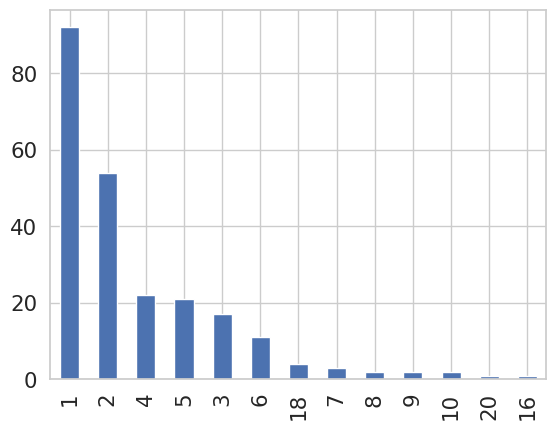

In [ ]:
pd.Series([r["actual_opt_tg_position"] for r in results]).value_counts().plot(kind='bar');

Какие места в получаемом списке занимает реальный состав оборудования, если рассматривать все основное оборудование

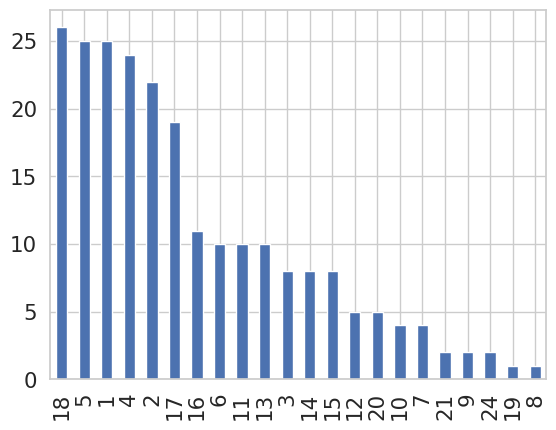

In [ ]:
pd.Series([r["actual_opt_position"] for r in results]).value_counts().plot(kind='bar');